In [3]:
import os
import torch
import torchaudio
import numpy
import random

### 데이터 로드

In [4]:
clean_path = './data/LibriSpeech/train-clean-100/19/198/19-198-0000.flac'
clean_wave, clean_rate = torchaudio.load(clean_path)

noise_path = './data/noise_datasets/urbansound8k/audio/fold1/7061-6-0-0.wav'
noise_wave, noise_rate = torchaudio.load(noise_path)

print(clean_wave.shape, clean_rate)
print(noise_wave.shape, noise_rate)

ImportError: TorchCodec is required for load_with_torchcodec. Please install torchcodec to use this function.

### sampling rate 통일

In [ ]:
noise_wave = torchaudio.transforms.Resample(orig_freq = noise_rate, new_freq = clean_rate)(noise_wave)
print(noise_wave.shape)  # 99225 * (16000/44100)

torch.Size([2, 36000])


### 채널 수 통일

In [ ]:
noise_wave = torch.mean(noise_wave, dim = 0, keepdim = True)
print(noise_wave.shape)

torch.Size([1, 36000])


### 두 오디오 길이 통일

In [ ]:
clean_len = clean_wave.shape[-1]
print(clean_len)

noise_len = noise_wave.shape[-1]
print(noise_len)

31440
36000


In [ ]:
if clean_len > noise_len:
    repeat_factor = clean_len // noise_len + 1
    noise_wave = torch.cat([noise_wave] * repeat_factor, dim = 1)
    noise_wave = noise_wave[..., :clean_len ]

elif clean_len < noise_len:
    start_idx = random.randint(0, noise_len - clean_len)
    noise_wave = noise_wave[..., start_idx:start_idx + clean_len]

else: clean_wave, noise_wave

print(clean_wave.shape)
print(noise_wave.shape)

torch.Size([1, 31440])
torch.Size([1, 31440])


### Mixing 비율 설정

In [ ]:
def calculate_alpha(clean, noise, target_snr_dB):  # target_snr : dB 단위
    P_clean = torch.mean(clean ** 2) + 1e-9
    P_noise = torch.mean(noise ** 2) + 1e-9
    target_ratio = 10 ** (target_snr_dB/10.0)  # dB -> 일반적인 비율로 변환
    alpha = torch.sqrt(P_clean / P_noise * target_ratio)

    return alpha

### Mixing

In [ ]:
def mix(clean, noise, target_snr_dB):
    alpha = calculate_alpha(clean, noise, target_snr_dB)
    scaled_noise = alpha * noise
    mixed_audio = clean + scaled_noise
    
    return mixed_audio, clean, target_snr_dB

In [ ]:
snr_dB = random.uniform(0, 15)
mixed_audio, clean_wave, target_snr_dB = mix(clean_wave, noise_wave, snr_dB)
print(snr_dB)
print(mixed_audio, mixed_audio.shape)
print(clean_wave, clean_wave.shape)

5.018015195963719
tensor([[0.0623, 0.0990, 0.0319,  ..., 0.0040, 0.0052, 0.0050]]) torch.Size([1, 31440])
tensor([[0.0044, 0.0033, 0.0031,  ..., 0.0047, 0.0060, 0.0060]]) torch.Size([1, 31440])


In [ ]:
torchaudio.save('mixed_audio_example.flac', mixed_audio, clean_rate)

<function matplotlib.pyplot.show(close=None, block=None)>

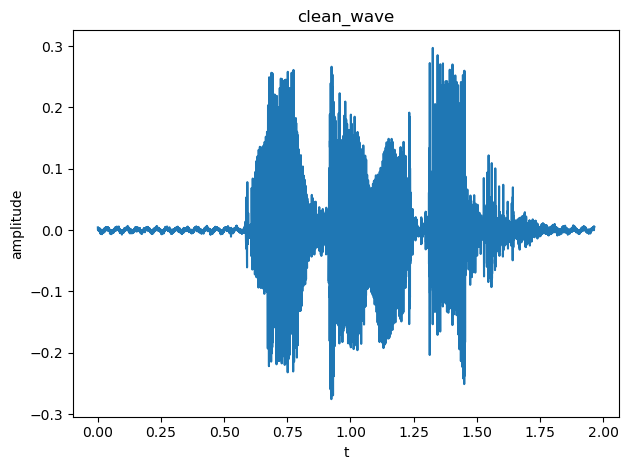

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

clean_wave_1d = clean_wave.squeeze().numpy()
time = np.arange(len(clean_wave_1d)) / clean_rate
plt.plot(time, clean_wave_1d)
plt.title('clean_wave')
plt.xlabel('t')
plt.ylabel('amplitude')
plt.tight_layout()
plt.show


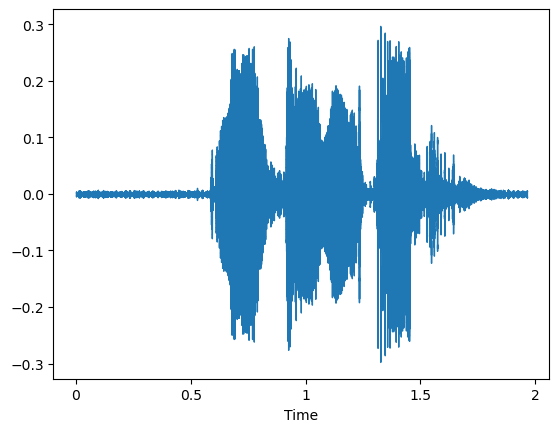

In [ ]:
import librosa

librosa.display.waveshow(clean_wave_1d, sr=clean_rate)


<function matplotlib.pyplot.show(close=None, block=None)>

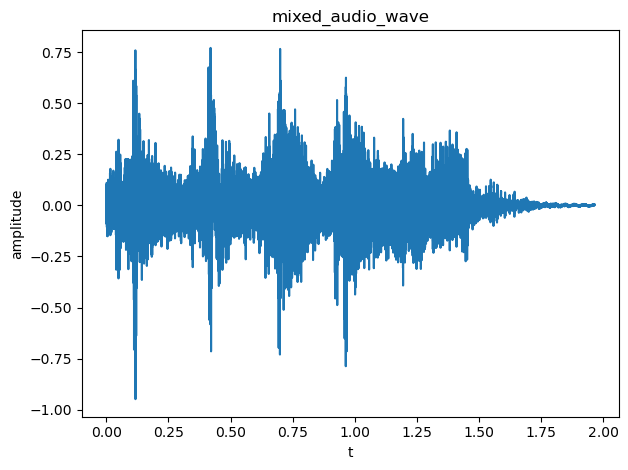

In [ ]:
mixed_audio_1d = mixed_audio.squeeze().numpy()
time = np.arange(len(mixed_audio_1d)) / clean_rate
plt.plot(time, mixed_audio_1d)
plt.title('mixed_audio_wave')
plt.xlabel('t')
plt.ylabel('amplitude')
plt.tight_layout()
plt.show

In [ ]:
import torch
import torchaudio
import torchaudio.transforms as T
import numpy as np
import random
import os

# --- 1. AudioMixer 클래스 정의 (이전과 동일) ---
class AudioMixer:
    def __init__(self, snr_range_db=(0, 15)):
        self.snr_min = snr_range_db[0]
        self.snr_max = snr_range_db[1]

    def _match_lengths(self, clean, noise):
        clean_len = clean.shape[-1]
        noise_len = noise.shape[-1]
        if clean_len > noise_len:
            repeat_factor = clean_len // noise_len + 1
            noise = torch.cat([noise] * repeat_factor, dim=-1)
            noise = noise[..., :clean_len]
        elif noise_len > clean_len:
            start_idx = random.randint(0, noise_len - clean_len)
            noise = noise[..., start_idx : start_idx + clean_len]
        return clean, noise

    def _calculate_alpha(self, clean, noise, target_snr_db):
        P_clean = torch.mean(clean**2) + 1e-9
        P_noise = torch.mean(noise**2) + 1e-9
        target_ratio = 10**(target_snr_db / 10.0)
        alpha = torch.sqrt(P_clean / (P_noise * target_ratio))
        return alpha

    def mix(self, clean_audio, noise_audio, target_snr_db=None):
        if isinstance(clean_audio, np.ndarray):
            clean_audio = torch.from_numpy(clean_audio).float()
        if isinstance(noise_audio, np.ndarray):
            noise_audio = torch.from_numpy(noise_audio).float()
        clean_audio, noise_audio = self._match_lengths(clean_audio, noise_audio)
        if target_snr_db is None:
            used_snr_db = random.uniform(self.snr_min, self.snr_max)
        else:
            used_snr_db = target_snr_db
        alpha = self._calculate_alpha(clean_audio, noise_audio, used_snr_db)
        scaled_noise = alpha * noise_audio
        mixed_audio = clean_audio + scaled_noise
        return mixed_audio, clean_audio, used_snr_db

# --- 2. 실제 파일 로드 및 전처리 ---
print("--- AudioMixer 실제 파일 테스트 (전처리 포함) ---")

TARGET_SAMPLE_RATE = 16000 # 모든 오디오를 이 SR로 통일

# --- 1. Clean 오디오 로드 ---
clean_path = './data/LibriSpeech/train-clean-100/19/198/19-198-0000.flac'
clean_wave_orig, clean_rate_orig = torchaudio.load(clean_path)

print(f"[Clean 로드] 원본 SR: {clean_rate_orig} Hz, 원본 형태: {clean_wave_orig.shape}")

# --- 2. Noise 오디오 로드 ---
# (참고: soundata를 사용하면 SR과 채널을 자동으로 처리해줄 수도 있습니다.)
# (하지만 여기서는 torchaudio.load를 직접 사용한 경우를 가정합니다.)
noise_path = './data/noise_datasets/urbansound8k/audio/fold1/7061-6-0-0.wav'
noise_wave_orig, noise_rate_orig = torchaudio.load(noise_path)

print(f"[Noise 로드] 원본 SR: {noise_rate_orig} Hz, 원본 형태: {noise_wave_orig.shape}")

# --- 3. 전처리: 샘플링 레이트 통일 (Resampling) ---
print(f"\n[전처리 1] 모든 오디오를 {TARGET_SAMPLE_RATE} Hz로 리샘플링합니다.")

# Clean (16000Hz -> 16000Hz 이므로 변화 없음)
if clean_rate_orig != TARGET_SAMPLE_RATE:
    resampler_clean = T.Resample(clean_rate_orig, TARGET_SAMPLE_RATE)
    clean_wave = resampler_clean(clean_wave_orig)
else:
    clean_wave = clean_wave_orig

# Noise (44100Hz -> 16000Hz)
if noise_rate_orig != TARGET_SAMPLE_RATE:
    resampler_noise = T.Resample(noise_rate_orig, TARGET_SAMPLE_RATE)
    noise_wave = resampler_noise(noise_wave_orig)
else:
    noise_wave = noise_wave_orig

print(f"  - Clean 리샘플링 후 형태: {clean_wave.shape}")
print(f"  - Noise 리샘플링 후 형태: {noise_wave.shape}")


# --- 4. 전처리: 채널 수 통일 (Stereo -> Mono) ---
print("\n[전처리 2] 스테레오(채널 2개) 오디오를 모노(채널 1개)로 변환합니다.")

# Clean (이미 모노이므로 변화 없음)
if clean_wave.shape[0] > 1:
    clean_wave = torch.mean(clean_wave, dim=0, keepdim=True)
    print("  - Clean 오디오를 모노로 변환했습니다.")
else:
    print("  - Clean 오디오는 이미 모노입니다.")

# Noise (스테레오 -> 모노)
if noise_wave.shape[0] > 1:
    # 2개 채널의 평균을 내어 1개 채널로 만듦
    noise_wave = torch.mean(noise_wave, dim=0, keepdim=True)
    print("  - Noise 오디오를 모노로 변환했습니다.")
else:
    print("  - Noise 오디오는 이미 모노입니다.")

print(f"\n최종 Clean 형태: {clean_wave.shape}")
print(f"최종 Noise 형태: {noise_wave.shape}")


# --- 5. AudioMixer로 믹싱 ---
print("\n[믹싱 실행] 5.0 dB SNR로 믹싱을 테스트합니다...")

mixer = AudioMixer()
TEST_SNR = 5.0
noisy_output, clean_target, snr_used = mixer.mix(
    clean_wave, noise_wave, target_snr_db=TEST_SNR
)

print(f"  - 믹싱 후 Noisy 형태: {noisy_output.shape}")
print(f"  - 믹싱 후 Clean 형태: {clean_target.shape}")
print("  - 검증: 모든 파일의 SR과 채널, 길이가 동일하게 처리되었습니다.")

# --- 6. 결과 파일로 저장 ---
print("\n[결과 저장] TEST_OUTPUT_... .wav 파일로 저장합니다.")
try:
    torchaudio.save("TEST_OUTPUT_noisy.wav", noisy_output, TARGET_SAMPLE_RATE)
    torchaudio.save("TEST_OUTPUT_clean_target.wav", clean_target, TARGET_SAMPLE_RATE)
    
    print("\n✅ 성공: 'TEST_OUTPUT_noisy.wav' 와 'TEST_OUTPUT_clean_target.wav' 파일이 저장되었습니다.")
    print("두 파일을 직접 들어보고 노이즈가 잘 섞였는지 확인해보세요!")

except Exception as e:
    print(f"❌ 파일 저장 실패: {e}")